In [8]:
# Import all necessary libraries
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier# Step1: Create data set
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.special import expit
from sklearn.metrics import classification_report
from sklearn import datasets  
from sklearn.metrics import accuracy_score 
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

In [9]:
# Define the number of examples.
N = 1000
# gerar conjunto de Luas 
x,y =  make_moons(n_samples=10000, noise=0.4, random_state=42)

In [10]:
# conjunto de treinamento de teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [11]:
# Use o Grid Search com validação cruzada (tente varios valores para max_leaf_node)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    3.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
  

In [12]:
n_trees = 1000
n_instances = 100

mini_sets = []
mini_sets2=[]

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
#USAR O PARAMETRO train_size TAMBEM SERVE E DA O RESULTADO IDENTICO 

rs2 = ShuffleSplit(n_splits=n_trees, train_size=n_instances,random_state=42) #tambem serve

for mini_train_index, mini_test_index in rs.split(X_train):
    #print("TRAIN size:", len(mini_train_index), "TEST size:", len(mini_test_index) )
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

for mini_train_index, mini_test_index in rs2.split(X_train):
    #print("TRAIN size:", len(mini_train_index), "TEST size:", len(mini_test_index) )
    X_mini_train2 = X_train[mini_train_index]
    y_mini_train2 = y_train[mini_train_index]
    mini_sets2.append((X_mini_train2, y_mini_train2))
# As "n_trees" amostras de treinamento estão em "mini_sets".
print(len(mini_sets))
print(len(mini_sets2))
print(mini_sets[0][0][0],mini_sets2[0][0][0])
#são identicos

1000
1000
[0.9645406  1.00563146] [0.9645406  1.00563146]


In [13]:
# copiando a melhor configuração da tree para todas as "n_trees" trees. 
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    # para cada conjunto de treinamento (mini_train), treinamos as nossas trees
    tree.fit(X_mini_train, y_mini_train)
    # fazemos a predição no conjunto de teste
    y_pred = tree.predict(X_test)
    # e calculamos a acurácia de cada predição
    accuracy_scores.append(accuracy_score(y_test, y_pred))
# média das acurácias
np.mean(accuracy_scores)

0.7950088000000001

In [14]:
print(np.max(accuracy_scores),np.min(accuracy_scores))

0.85 0.6972


In [15]:
#dou de input a amostra de teste e a "floresta" já treinada

def MyClassifierRandomForest(X_test,forest):
    n_trees = len(forest)
    Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
    for tree_index, tree in enumerate(forest):
        Y_pred[tree_index] = tree.predict(X_test)
    
    y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
    n_voted = n_votes.reshape([-1])
    y_pred_voted = y_pred_majority_votes.reshape([-1])
    return n_voted,y_pred_voted,Y_pred

In [16]:
n_voted,y_pred_voted,Y_pred = MyClassifierRandomForest(X_test,forest )
print(accuracy_score(y_test, y_pred_voted))

0.8656


0.8656
336
0.8656
Posição do experimento classificado errado: [-0.33285914  0.49147429]


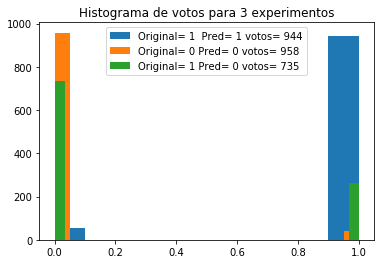

In [17]:
n_voted,y_pred_voted,Y_pred = MyClassifierRandomForest(X_test,forest )
print(accuracy_score(y_test, y_pred_voted))

#Os 3 histogramas a continuação mostram a proporção de "votos" para as instancias/experimentos [0], [-1] (o ultimo), o o decimo da lista dos "errados"

plt.hist(Y_pred[:,0],bins=10,label="Original= {:}  Pred= {:} votos= {:d}".format(y_test[0],y_pred_voted[0],int(n_voted[0])))

plt.hist(Y_pred[:,-1],bins=20,label="Original= {:} Pred= {:} votos= {:d}".format(y_test[-1],y_pred_voted[-1],int(n_voted[-1])))

w=np.where(y_test!=y_pred_voted) #selecionar as instancias onde o random forest escolheu errado
print(len(w[0]))
print(1-len(w[0])/len(y_test)) # checar que é o mesmo valor que o accuracy_score
ind10 = w[0][10]
plt.hist(Y_pred[:,ind10],bins=30,label="Original= {:} Pred= {:} votos= {:d}".format(y_test[ind10],y_pred_voted[w[0][10]],int(n_voted[ind10])))
plt.title("Histograma de votos para 3 experimentos")
plt.legend(loc="upper center")

print("Posição do experimento classificado errado:",X_test[ind10])